# Analyse des ventes 📚 Rester livres 

## Questions
- Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
- Y a-t-il une corrélation entre l'âge des clients et :
    - le montant total des achats ?
    - la fréquence d’achat (ie. nombre d'achats par mois par exemple) ?
    - la taille du panier moyen (en nombre d’articles) ?
    - les catégories de produits achetés ?

## Sommaire
- [Ressources](#Ressources)
    - [Imports](#Imports)
    - [Fonctions](#Fonctions)
- [Exploration](#Exploration)
    - [Datasets](#Datasets)
    - [Doublons](#Doublons)
    - [Clients](#Clients)
    - [Produits](#Produits)
    - [Transactions](#Transactions)
- [Nettoyage](#Nettoyage)
    - [Jointures](#Jointures)
    - [Valeurs aberrantes](#Valeurs-aberrantes)
    - [Dates manquantes](#Dates-manquantes)
    - [Valeurs manquantes](#Valeurs-manquantes)
- [Analyse](#Analyse)
    - [Nouvelles variables](#Nouvelles-variables)
    - [Clients B2B](#Clients-B2B)
    - [Clients B2C](#Clients-B2C)
    - [Produits](#Produits)
- [Tests](#Tests)
    - [Sexe et catégorie](#Sexe-et-catégorie)
    - [Âge et catégorie](#Âge-et-catégorie)
    - [Âge et prix](#Âge-et-prix)
    - [Catégorie et prix](#Catégorie-et-prix)
- [Conclusion](#Références)
    - [Résultats](#Résultats)
    - [Recommandations](#Recommandations)
    - [Références](#Références)

# Ressources

## Imports

In [1]:
# Librairies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import researchpy as rp
from datetime import datetime
from scipy.special import boxcox1p
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Styles Seaborn
sns.set() # Seaborn avec plt.
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
sns.set_palette('Set3')

In [3]:
# Dataframes
url = 'sources/'
clients = pd.read_csv(url + 'customers.csv')
produits = pd.read_csv(url + 'products.csv')    
transactions = pd.read_csv(url + 'transactions.csv')

## Fonctions

In [4]:
# Fonction de vérification et suppression des doublons
def check_duplicates(df):
    print(    
        len(df), 'lignes avant suppression des doublons\n' + # Nombre de lignes avant suppression
        'Nombre de doublons :', len(df) - len(df.drop_duplicates())) # Nombre de doublons 
    df.drop_duplicates(inplace=True) # Suppression des doublons
    print(len(df), 'lignes après suppression') # Nombre de lignes après suppression

In [5]:
# Fonction d'exploration
def exploration(df):
    print('Info ↓')
    print(df.info(), '\n') # Infos dataset (variables, nulls, types d'objets)
    for i in range(0, len(df.columns)): # Variables
        print('Variable', df.columns[i], ':')         
        print(df.iloc[:, i].describe()) # Nom de variable
        print(sum(df.iloc[:, i].isna()), 'Nan') # Nombre de Nan
        print(df.shape[0] - np.count_nonzero(df.iloc[:, i]), 'zéros') # Nombre de 0
        print(len(df.iloc[:, i].unique()), 'valeurs uniques') # Nombre de valeurs uniques
        print(len(df.iloc[:, i]) - len(df.iloc[:, i].drop_duplicates()), 'doublons\n') # Nombre de doublons

In [6]:
# Fonction de vérification de la clé primaire
def check_pk(df_pk):
  table_length = len(df_pk) - len(df_pk.drop_duplicates())
  if table_length == 0:
    print('C\'est bien une clé primaire (0 doublon)')
  else:
    print('Ce n\'est pas une clé primaire (', table_length, 'doublons )')

In [7]:
# Fonction de comparaison d'une clé entre 2 dataframes
def compare_keys(variable, df1, df1_name, df2, df2_name):
    df1_keys = pd.DataFrame(df1[variable].unique()) # Projection de df1 sur la variable
    df2_keys = pd.DataFrame(df2[variable].unique()) # Projection de df2 transactions sur la variable
    print( 'Variable \'' + variable + '\' sur', df1_name,
        ':', len(df1_keys), 'valeurs uniques') # Longueur et valeurs uniques de la variable dans df1
    print( 'Variable \'' + variable + '\' sur', df2_name,
        ':', len(df2_keys), 'valeurs uniques') # Longueur et valeurs uniques de la variable dans df2
    keys_1 = df1_keys.merge( # Clés de df2 non présentes dans df1
        df2_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']  
    print('Clés de', df2_name, 'non présentes dans', df1_name + ' : ', len(keys_1))   
    keys_2 = df2_keys.merge( # Clés de df1 non présentes dans df2
        df1_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
    print('Clés de', df1_name, 'non présentes dans', df2_name + ' : ', len(keys_2))

Courbe de Lorenz
Incide de Gini : 0.3315496836072902


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


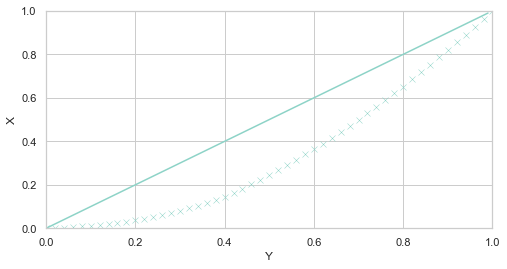

In [8]:
# Courbe de Lorenz
def lorenz(samples, variable):
    X = variable.sample(samples).values
    X = np.sort(X)
    
    # Indice de Gini
    def gini(array):
        array
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_array)])
        return coef_*weighted_sum/(sorted_array.sum()) - const_
    print('Courbe de Lorenz\nIncide de Gini :', gini(X))
    
    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size)/(X_lorenz.size-1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x')

    # Diagonale
    a = np.arange(0,1,.01)
    x = a
    y = a
    sns.lineplot(x,y)
    
    # Affichage
    sns.set(rc={'figure.figsize':(5,5)})
    sns.set_style('whitegrid')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()
    
# Exemple
variable = pd.Series(np.random.rand(1000))
lorenz(50, variable)

In [9]:
# Test de Shapiro
def test_shapiro(samples, data):
    variable = data.sample(samples)
    stat, p = stats.shapiro(variable)
    print('Test de Shapiro')
    print('Stat = %.3f\np-value = %.35f' % (stat, p))
    if p>.05:
        print('H0 acceptée : distribution normale')
    else:
        print('H0 rejetée : distribution probablement pas normale')
    sns.histplot(variable, bins=25)
    plt.show()
    qqplot(variable, line='s')
    plt.show()

In [10]:
# Test de Pearson
def test_pearson(samples, data, variable1, variable2):
    df = data.sample(samples)
    stat, p = stats.pearsonr(df[variable1], df[variable2])
    print('Test de Pearson (2 quantitatives)')
    print('Stat = %.3f\np-value = %.35f' % (stat, p))
    if p > .05:
        print('H0: the two samples are independent.')
    else:
        print('H1: there is a dependency between the samples.')
    print('\nConditions :\n'
          '- Observations in each sample are independent and identically distributed (iid).',
          '\n- Observations in each sample are normally distributed.',
          '\n- Observations in each sample have the same variance.')
    sns.lmplot(data=df, x=variable1, y=variable2)
    plt.show()

# Exploration

## Datasets

Trois jeux de données :
- **clients**
- **produits**
- **transactions**

In [11]:
# Nouveaux noms de variables
clients.columns = ['ID_client', 'Sexe', 'Naissance']
produits.columns = ['ID_produit', 'Prix', 'Catégorie']
transactions.columns = ['ID_produit', 'Date', 'ID_session', 'ID_client']

In [12]:
clients.sample()

,ID_client,Sexe,Naissance
1720,c_2717,m,1950


In [13]:
produits.sample()

,ID_produit,Prix,Catégorie
745,1_122,35.93,1


In [14]:
transactions.sample()

,ID_produit,Date,ID_session,ID_client
46512,0_1353,2021-11-12 23:46:48.737302,s_118749,c_3454


## Doublons
- Vérification des duplicats dans chaque dataframe, pour pouvoir déterminer leurs clés primaires pendant l'exploration
- Aucun doublon dans **clients** et **produits**
- 126 doublons supprimés dans **transactions**

In [15]:
# Fonction de vérification et suppression des doublons
def check_duplicates(df):
    print(    
        len(df), 'lignes avant suppression des doublons\n' + # Nombre de lignes avant suppression
        'Nombre de doublons :', len(df) - len(df.drop_duplicates())) # Nombre de doublons 
    df.drop_duplicates(inplace=True) # Suppression des doublons
    print(len(df), 'lignes après suppression') # Nombre de lignes après suppression

In [16]:
# Vérification des doublons de clients
check_duplicates(clients)

8623 lignes avant suppression des doublons
Nombre de doublons : 0
8623 lignes après suppression


In [17]:
# Vérification des doublons de produits
check_duplicates(produits)

3287 lignes avant suppression des doublons
Nombre de doublons : 0
3287 lignes après suppression


In [18]:
# Vérification et suppression des doublons de transactions
check_duplicates(transactions)

337016 lignes avant suppression des doublons
Nombre de doublons : 126
336890 lignes après suppression


## Clients

8623 individus et 3 variables :
- *ID_client* : 8623 identifiants client uniques (aucun doublon)
- *Sexe* : 2 modalités de genre (f et m)
- *Naissance* : année de naissance, de 1929 à 2004

✔️ Aucune valeur aberrante ou manquante : pas de nettoyage nécessaire

🔑 Clé primaire : *ID_client*

In [19]:
clients.sample(3)

,ID_client,Sexe,Naissance
7324,c_4603,m,1961
1826,c_4214,m,1998
6812,c_4025,m,2004


In [20]:
# Exploration des données de clients
exploration(clients)

Info ↓
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID_client  8623 non-null   object
 1   Sexe       8623 non-null   object
 2   Naissance  8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 269.5+ KB
None 

Variable ID_client :
count       8623
unique      8623
top       c_2091
freq           1
Name: ID_client, dtype: object
0 Nan
0 zéros
8623 valeurs uniques
0 doublons

Variable Sexe :
count     8623
unique       2
top          f
freq      4491
Name: Sexe, dtype: object
0 Nan
0 zéros
2 valeurs uniques
8621 doublons

Variable Naissance :
count    8623.000000
mean     1978.280877
std        16.919535
min      1929.000000
25%      1966.000000
50%      1979.000000
75%      1992.000000
max      2004.000000
Name: Naissance, dtype: float64
0 Nan
0 zéros
76 valeurs uniques
8547 doublons



In [21]:
# Vérification de la clé primaire sur 'ID_client'
check_pk(clients['ID_client'])

C'est bien une clé primaire (0 doublon)


## Produits

3287 lignes et 3 variables :
- *ID_produit* : 3287 identifiants produit (aucun doublon)
- *Catégorie* : 3 modalités ordinales (0, 1 et 2)
- *Prix* : prix de -1 à 300 (-1 est une valeur aberrante)

✔️ Aucune valeur manquante

❌ Des prix sont inférieurs à 0

🔑 Clé primaire : *ID_produit*

In [22]:
produits.sample(3)

,ID_produit,Prix,Catégorie
3083,0_1973,3.99,0
380,0_2148,7.32,0
3196,2_238,93.92,2


In [23]:
# Exploration des données de produits
exploration(produits)

Info ↓
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID_produit  3287 non-null   object 
 1   Prix        3287 non-null   float64
 2   Catégorie   3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB
None 

Variable ID_produit :
count      3287
unique     3287
top       0_704
freq          1
Name: ID_produit, dtype: object
0 Nan
0 zéros
3287 valeurs uniques
0 doublons

Variable Prix :
count    3287.000000
mean       21.856641
std        29.847908
min        -1.000000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: Prix, dtype: float64
0 Nan
0 zéros
1455 valeurs uniques
1832 doublons

Variable Catégorie :
count    3287.000000
mean        0.370246
std         0.615387
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000

In [24]:
# Vérification de la clé primaire sur 'ID_produit'
check_pk(produits['ID_produit'])

C'est bien une clé primaire (0 doublon)


## Transactions

336890 lignes et 4 variables :
- *ID_client* : clé étrangère vers **clients**
- *ID_produit* : clé étrangère vers **produits**
- *ID_session* : 169195 identifiants uniques de session
- *Date* : 336855 dates uniques (une session peut compter plusieurs dates de transaction)

✔️ Aucune valeur manquante

❌ *Date* n'est pas au format timestamp, et inclut le préfixe 'test_' dans les premières lignes (valeurs aberrantes)

🔑 2 clés étrangères (*ID_client* et *ID_produit*) vers les clés primaires de **clients** et **produits**

🔑 Clé primaire : *Date* + *ID_client*

In [25]:
transactions.sample(3)

,ID_produit,Date,ID_session,ID_client
225660,1_661,2022-02-05 13:53:57.421057,s_160386,c_2312
300779,0_1229,2021-05-14 17:20:52.613668,s_34491,c_7065
117523,0_1118,2022-01-14 18:05:51.455831,s_149804,c_2595


In [26]:
# Exploration des données de transactions
exploration(transactions)

Info ↓
<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID_produit  336890 non-null  object
 1   Date        336890 non-null  object
 2   ID_session  336890 non-null  object
 3   ID_client   336890 non-null  object
dtypes: object(4)
memory usage: 12.9+ MB
None 

Variable ID_produit :
count     336890
unique      3266
top        1_369
freq        1081
Name: ID_produit, dtype: object
0 Nan
0 zéros
3266 valeurs uniques
333624 doublons

Variable Date :
count                              336890
unique                             336855
top       test_2021-03-01 02:30:02.237432
freq                                    2
Name: Date, dtype: object
0 Nan
0 zéros
336855 valeurs uniques
35 doublons

Variable ID_session :
count     336890
unique    169195
top          s_0
freq          74
Name: ID_session, dtype: object
0 Nan
0 zéros
169195 valeurs uniq

In [27]:
# Vérification de la clé primaire sur 'Date' + 'ID client'
check_pk(transactions[['Date', 'ID_client']])

C'est bien une clé primaire (0 doublon)


# Nettoyage

## Jointures

- 336890 individus et 8 variables
- Tous les clients ayant passé commande figurent dans **clients**
- Un seul des identifiants produit de **transactions** ne figure pas dans **produits**
- 21 clients enregistrés dans **clients** n'ont pas passé commande
- 22 produits référencés dans **produits** n'ont pas été vendus

💡 Les clés étrangères de **transactions** ont moins de valeurs uniques que les clés primaires de **clients** et **produits**. La jointure ne préserve donc que les clés de **transactions**.

❌ 103 valeurs manquantes apparaissent dans *Prix* et *Catégorie*

🔑 La clé primaire reste celle de **transactions** (*Date* + *ID_client*)

In [28]:
# Comparaison de la clé 'ID_client' entre transactions et clients
compare_keys('ID_client', clients, 'clients', transactions, 'transactions')

Variable 'ID_client' sur clients : 8623 valeurs uniques
Variable 'ID_client' sur transactions : 8602 valeurs uniques
Clés de transactions non présentes dans clients :  0
Clés de clients non présentes dans transactions :  21


In [29]:
# Comparaison de la clé 'ID_produit' entre transactions et produits
compare_keys('ID_produit', produits, 'produits', transactions, 'transactions')

Variable 'ID_produit' sur produits : 3287 valeurs uniques
Variable 'ID_produit' sur transactions : 3266 valeurs uniques
Clés de transactions non présentes dans produits :  1
Clés de produits non présentes dans transactions :  22


In [30]:
# Jointure externe gauche entre transactions et clients, sur 'ID_client'
data = pd.merge(transactions, clients, how='left', on='ID_client')
data.sample(3)

,ID_produit,Date,ID_session,ID_client,Sexe,Naissance
158954,1_99,2021-03-03 07:17:46.563156,s_1082,c_643,f,1976
124079,1_90,2021-04-01 16:31:12.052372,s_14546,c_8505,m,1962
310862,1_259,2022-02-28 19:20:40.130507,s_172322,c_466,m,1940


In [31]:
# Jointure externe gauche avec produits à droite, sur 'ID_produit'
data = pd.merge(data, produits, how='left', on='ID_produit')
data.sample(3)

,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
182786,0_1468,2021-10-07 23:41:35.470829,s_101505,c_1468,m,2002,6.08,0.0
141097,1_407,2021-07-07 23:17:22.511394,s_59288,c_8116,f,1983,15.99,1.0
106967,1_612,2021-11-16 17:02:26.246294,s_120577,c_688,m,1994,29.55,1.0


In [32]:
# Exploration du résultat des jointures
exploration(data)

Info ↓
<class 'pandas.core.frame.DataFrame'>
Int64Index: 336890 entries, 0 to 336889
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_produit  336890 non-null  object 
 1   Date        336890 non-null  object 
 2   ID_session  336890 non-null  object 
 3   ID_client   336890 non-null  object 
 4   Sexe        336890 non-null  object 
 5   Naissance   336890 non-null  int64  
 6   Prix        336787 non-null  float64
 7   Catégorie   336787 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 23.1+ MB
None 

Variable ID_produit :
count     336890
unique      3266
top        1_369
freq        1081
Name: ID_produit, dtype: object
0 Nan
0 zéros
3266 valeurs uniques
333624 doublons

Variable Date :
count                              336890
unique                             336855
top       test_2021-03-01 02:30:02.237432
freq                                    2
Name: Date, dtype: object
0 Nan
0 z

In [33]:
# Vérification de la clé primaire sur 'Date' + 'ID client'
check_pk(data[['Date', 'ID_client']])

C'est bien une clé primaire (0 doublon)


## Valeurs aberrantes

- 74 dates incluent le préfixe 'test_'
- Les 74 premières valeurs de *Prix* sont négatives (-1)

💡 Les valeurs aberrantes correspondent aux 74 mêmes lignes test, qui ont toutes pour attributs :
- 'T_0' dans *ID_produit*
- 's_0' dans *ID_session*
- 'ct_0' et 'ct_1' dans *ID_client*

✔️ Suppression des lignes test

🔑 Nouvelle clé primaire : *Date* (il y a autant de transactions que de dates)

In [34]:
# Affichage des 77 dernières valeurs de 'Date'
data.sort_values(by='Date', ascending=False).head(77)

,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
38778,T_0,test_2021-03-01 02:30:02.237450,s_0,ct_0,f,2001,-1.00,0.0
203184,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0,f,2001,-1.00,0.0
245271,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1,m,2001,-1.00,0.0
317233,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0,f,2001,-1.00,0.0
26814,T_0,test_2021-03-01 02:30:02.237447,s_0,ct_1,m,2001,-1.00,0.0
...,...,...,...,...,...,...,...,...
133414,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_0,f,2001,-1.00,0.0
22347,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1,m,2001,-1.00,0.0
79882,0_1775,2022-02-28 23:59:58.040472,s_172423,c_1460,m,1989,6.99,0.0
301419,0_1403,2022-02-28 23:59:02.381670,s_172423,c_1460,m,1989,15.99,0.0


In [35]:
# Affichage des 77 premières valeurs de 'Prix'
data.sort_values(by='Prix').head(77)

,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
109577,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1,m,2001,-1.00,0.0
59039,T_0,test_2021-03-01 02:30:02.237413,s_0,ct_0,f,2001,-1.00,0.0
47169,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_1,m,2001,-1.00,0.0
129823,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0,f,2001,-1.00,0.0
151885,T_0,test_2021-03-01 02:30:02.237435,s_0,ct_1,m,2001,-1.00,0.0
...,...,...,...,...,...,...,...,...
317233,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0,f,2001,-1.00,0.0
137476,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0,f,2001,-1.00,0.0
57641,0_528,2021-06-24 18:55:00.312636,s_53240,c_5636,f,1989,0.62,0.0
25621,0_202,2021-05-14 15:26:20.597059,s_34456,c_5510,f,1941,0.62,0.0


In [36]:
# Lignes communes au préfixe 'test_' et au prix -1
lignes_test = data[(data['Prix'] == -1) & (data['Date'].str.contains('test_'))]
lignes_test

,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
1431,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,m,2001,-1.0,0.0
2365,T_0,test_2021-03-01 02:30:02.237446,s_0,ct_1,m,2001,-1.0,0.0
2895,T_0,test_2021-03-01 02:30:02.237414,s_0,ct_1,m,2001,-1.0,0.0
5955,T_0,test_2021-03-01 02:30:02.237441,s_0,ct_0,f,2001,-1.0,0.0
7283,T_0,test_2021-03-01 02:30:02.237434,s_0,ct_1,m,2001,-1.0,0.0
...,...,...,...,...,...,...,...,...
264229,T_0,test_2021-03-01 02:30:02.237416,s_0,ct_1,m,2001,-1.0,0.0
288815,T_0,test_2021-03-01 02:30:02.237415,s_0,ct_1,m,2001,-1.0,0.0
293003,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_0,f,2001,-1.0,0.0
298292,T_0,test_2021-03-01 02:30:02.237423,s_0,ct_1,m,2001,-1.0,0.0


In [37]:
# Affichage des valeurs de 'ID_session', 'ID_prod' et 'ID_client' des 74 lignes test 
print(
    '\'ID_produit\' unique des lignes test :', lignes_test['ID_produit'].unique(),
    '\n\'ID_session\' unique des lignes test :', lignes_test['ID_session'].unique(),
    '\n\'ID_client\' unique des lignes test :', lignes_test['ID_client'].unique())

'ID_produit' unique des lignes test : ['T_0'] 
'ID_session' unique des lignes test : ['s_0'] 
'ID_client' unique des lignes test : ['ct_1' 'ct_0']


In [38]:
# Suppression des lignes test
len_data_before = len(data) # Nombre de lignes dans data avant drop
data.drop(lignes_test.index, inplace=True) # Suppression des lignes-test
print(len_data_before - len(data), 'lignes test supprimées dans data') # Nombre de lignes dans data après nettoyage
data.reset_index(inplace=True) # Réinitialisation des index de data

74 lignes test supprimées dans data


In [39]:
# Vérification de la nouvelle clé primaire ('Date')
check_pk(data['Date'])

C'est bien une clé primaire (0 doublon)


## Dates manquantes

✔️ Conversion de la variable *Date* en timestamp

💡 Données étalées sur 1 an, du 1er mars 2021 au 28 février 2022

❌ Les valeurs de la catégorie 1 sont manquantes au mois d'octobre

✔️ Suppression des transactions du mois d'octobre (6% du dataset)

In [40]:
print('Type de la variable \'Date\' :', type(data['Date'].loc[0])) # Type des valeurs de 'Date'
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d') # Conversion de la variable 'Date' en datetime
print('Convertie en :', type(data['Date'].loc[0])) # Type des valeurs après conversion

Type de la variable 'Date' : <class 'str'>
Convertie en : <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [41]:
# Dates les plus ancienne et récente
print('Première date :', data['Date'].min(), '\nDernière date :', data['Date'].max())

Première date : 2021-03-01 00:01:07.843138 
Dernière date : 2022-02-28 23:59:58.040472


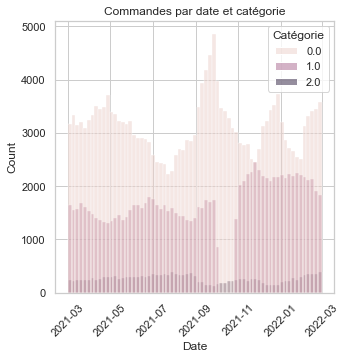

Absence de données pour la catégorie 1 au mois d'octobre


In [42]:
# Commandes par date et catégorie
sns.histplot(data, x='Date', hue='Catégorie')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
plt.title('Commandes par date et catégorie')
plt.xticks(rotation=45)
plt.show()
print('Absence de données pour la catégorie 1 au mois d\'octobre')

Nombre de lignes avant suppression du mois d'octobre : 336816
Nombre de lignes après suppression : 316170 ( 6.1 % du dataset écarté )


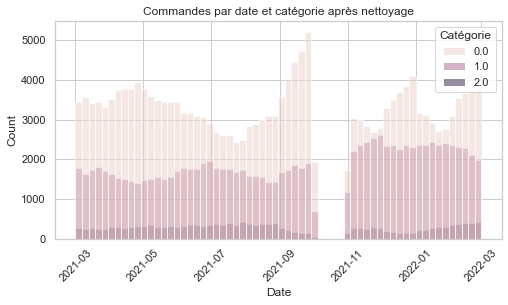

In [43]:
# Nombre de lignes dans data avant suppression du mois d'octobre
len_data_before = len(data)
print('Nombre de lignes avant suppression du mois d\'octobre :', len_data_before)

# Index des transactions mois octobre (toutes catégories)
octobre = data[(data['Date']>='2021-10-01') & (data['Date']<='2021-10-31')].index

# Suppression des données du mois d'octobre
data.drop(octobre, inplace=True)

# Nombre de lignes après suppression et pourcentage du dataset écarté
print('Nombre de lignes après suppression :', len(data), '(', 
    round(((len_data_before - len(data)) / len_data_before * 100), 1), '% du dataset écarté )')

# Commandes par date et catégorie
sns.histplot(data, x='Date', hue='Catégorie')
sns.set(rc={'figure.figsize':(8,2)})
sns.set_style('whitegrid')
plt.title('Commandes par date et catégorie après nettoyage')
plt.xticks(rotation=45)
plt.show()
sns.set(rc={'figure.figsize':(8,3)})

## Valeurs manquantes

- Les variables *Prix* et *Catégorie* ont des valeurs manquantes communes aux mêmes lignes
- Ces lignes correspondent au produit 0_2245, qui représente 0.03% du dataset

3 méthodes sont envisageables pour gérer ces valeurs :
- Supprimer les lignes concernées (sans impact vu la faible taille de l'échantillon)
- Déterminer une valeur fixe de prix et de catégorie
- Modéliser ces valeurs

### Lignes concernées
- Les variables *Prix* et *Catégorie* ont des valeurs manquantes
- Les valeurs manquantes concernent les mêmes 96 lignes 
- Toutes ces lignes concernent un seul idenfiant produit ('0_2245'), et 0.03% du dataset

💡 Avec son préfixe '0_', on peut supposer que le produit '0_2245' appartient à la catégorie 0

In [44]:
print('Nombre de lignes sans prix :', len(data[data['Prix'].isna()]))
print('Nombre de lignes sans catégorie :', len(data[data['Catégorie'].isna()]))
print('Nombre de lignes sans prix ni catégorie :', len(data[data['Catégorie'].isna() & data['Prix'].isna()]))

Nombre de lignes sans prix : 96
Nombre de lignes sans catégorie : 96
Nombre de lignes sans prix ni catégorie : 96


In [45]:
print('\'ID_produit\' unique des lignes sans catégorie:', 
    data[data['Catégorie'].isna()]['ID_produit'].unique())

print('\'ID_produit\' unique des lignes sans prix:', 
    data[data['Prix'].isna()]['ID_produit'].unique())

'ID_produit' unique des lignes sans catégorie: ['0_2245']
'ID_produit' unique des lignes sans prix: ['0_2245']


In [46]:
# Sous-échantillon sur les lignes sans prix ni catégorie
valeurs_manquantes = data[data['Catégorie'].isna() & data['Prix'].isna()]
valeurs_manquantes.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
210463,210524,0_2245,2021-04-18 08:28:11.501497,s_22209,c_3496,f,1957,NaN,NaN


In [47]:
# Proportion de l'échantillon par rapport au dataset
print('Le produit 0_2245 représente', round((len(valeurs_manquantes)/len(data)*100),2), '% du dataset')

Le produit 0_2245 représente 0.03 % du dataset


In [48]:
# Dataframe-test, sans NaN
data_test = data.dropna()

# Réduction de la variable 'ID_produit' à ses 2 premières caractères
data_test['ID_produit'] = data_test['ID_produit'].str[:2]

# Préfixes uniques dans 'ID_produit' pour chaque catégorie 
print('Préfixes unique dans \'ID_prod\' pour :')
for i in data_test['Catégorie'].unique():
    print('- la catégorie', i, ':',
        data_test[data.dropna()['Catégorie']==i]['ID_produit'].unique())

<ipython-input-48-a3345b6c4aa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['ID_produit'] = data_test['ID_produit'].str[:2]


Préfixes unique dans 'ID_prod' pour :
- la catégorie 0.0 : ['0_']
- la catégorie 2.0 : ['2_']
- la catégorie 1.0 : ['1_']


### Remplacement par analyse

- La distribution des dates du produit 2245 est semblable à l'ensemble des transactions
- Les femmes achètent légèrement plus le produit que les hommes 
- Chez les acheteurs du produit, la distribution des années de naissance est plus concentrée entre 1973 et 1984

✔️ Retenue des clients nés entre 1973 et 1984 pour déterminer les valeurs manquantes

💡 Dans cette population, les valeurs de remplacement les plus sûres sont celles les plus fréquentes (mode) :
- 0 en *Catégorie*
- 4.99 en *Prix*

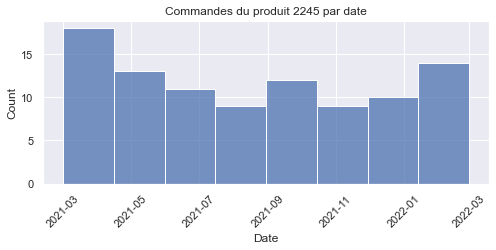

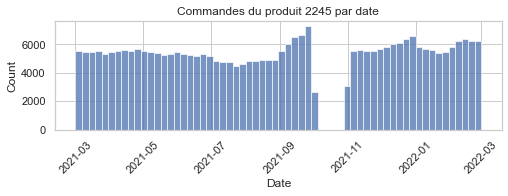

Pas d'indicateur via la date


In [49]:
# Commandes du produit 2245, par date
sns.histplot(valeurs_manquantes, x='Date')
sns.set(rc={'figure.figsize':(8,2)})
sns.set_style('whitegrid')
plt.title('Commandes du produit 2245 par date')
plt.xticks(rotation=45)
plt.show()

# Ensemble des commandes, par date
sns.histplot(data, x='Date')
sns.set(rc={'figure.figsize':(8,2)})
sns.set_style('whitegrid')
plt.title('Commandes du produit 2245 par date')
plt.xticks(rotation=45)
plt.show()

print('Pas d\'indicateur via la date')

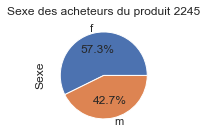

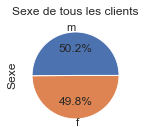

In [50]:
# Sexe des acheteurs du produit 2245
valeurs_manquantes['Sexe'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Sexe des acheteurs du produit 2245')
plt.show()

# Sexe de la population totale
data['Sexe'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Sexe de tous les clients')
plt.show()

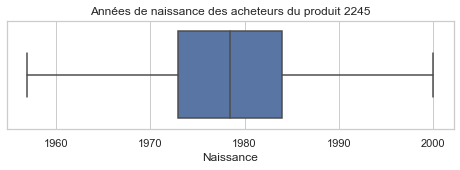

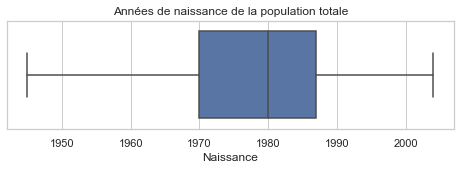

In [51]:
# Année de naissance des acheteurs du produit 2245
sns.boxplot(data=valeurs_manquantes, x='Naissance', showfliers=False)
sns.set(rc={'figure.figsize':(8,2)})
sns.set_style('whitegrid')
plt.title('Années de naissance des acheteurs du produit 2245')
plt.show()

# Année de naissance de la population totale
sns.boxplot(data=data, x='Naissance', showfliers=False)
sns.set(rc={'figure.figsize':(8,2)})
sns.set_style('whitegrid')
plt.title('Années de naissance de la population totale')
plt.show()

In [52]:
# Valeurs des quartiles de 'Naissance' sur l'échantillon
valeurs_manquantes_q1 = valeurs_manquantes['Naissance'].quantile(.25)
valeurs_manquantes_q2 = valeurs_manquantes['Naissance'].quantile(.5)
valeurs_manquantes_q3 = valeurs_manquantes['Naissance'].quantile(.75)
print('Quartile 1 :', int(valeurs_manquantes_q1),
    '\nQuartile 2 (médiane) :', int(valeurs_manquantes_q2),
    '\nQuartile 3 :', int(valeurs_manquantes_q3))

Quartile 1 : 1973 
Quartile 2 (médiane) : 1978 
Quartile 3 : 1984


In [53]:
data_2245_q = data[(data['Naissance'] >= valeurs_manquantes_q1) & (data['Naissance'] <= valeurs_manquantes_q3)]
data_2245_q

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
0,0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0.0
2,2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979,10.71,1.0
4,4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980,8.99,0.0
5,5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,f,1982,3.99,0.0
7,7,0_1627,2021-09-19 14:54:52.410362,s_92294,c_1422,f,1980,3.99,0.0
...,...,...,...,...,...,...,...,...,...
336792,336866,0_1631,2021-08-23 20:20:44.440704,s_79762,c_6798,m,1984,10.99,0.0
336793,336867,0_1434,2022-01-10 06:48:49.678199,s_147656,c_1288,f,1982,8.58,0.0
336797,336871,1_170,2021-11-12 17:28:12.431649,s_118601,c_7386,f,1978,14.22,1.0
336798,336872,0_1596,2021-03-22 04:31:42.170467,s_9750,c_4147,m,1980,10.36,0.0


In [54]:
# Transactions de data dont 'Naissance' appartient à l'espace interquartile de l'échantillon
print('Les clients nés entre 1973 et 1984 représentent',
      int(len(data_2245_q) / len(data) * 100), '% du total des transactions')

Les clients nés entre 1973 et 1984 représentent 39 % du total des transactions


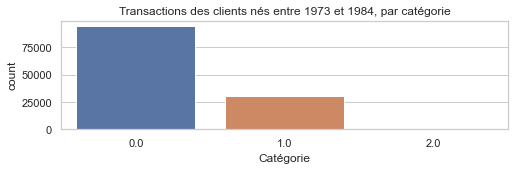

Médiane :  0.0 
Mode : [0.]


In [55]:
# Transactions des clients nés entre 1973 et 1984, par catégorie
sns.countplot(data=data_2245_q, x='Catégorie')
sns.set(rc={'figure.figsize':(8,3)})
sns.set_style('whitegrid')
plt.title('Transactions des clients nés entre 1973 et 1984, par catégorie')
plt.show()

# Médiane et mode des catégories
print('Médiane : ', data_2245_q['Catégorie'].quantile(.5), '\nMode :', data_2245_q['Catégorie'].mode().unique())

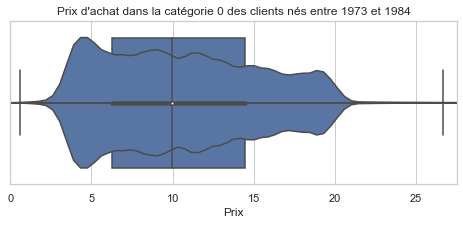

Médiane :  9.99 
Mode : [4.99]


In [56]:
# Prix d'achat dans la catégorie 0 des clients nés entre 1973 et 1984
data_2245_q_0 = data_2245_q[data_2245_q['Catégorie']==0]
sns.violinplot(data=data_2245_q_0, x='Prix', showfliers=False)
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
sns.boxplot(data=data_2245_q_0, x='Prix', showfliers=False)
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
plt.title('Prix d\'achat dans la catégorie 0 des clients nés entre 1973 et 1984')
plt.xlim([0,27.5])
plt.show()

# Médiane et mode des prix de vente
print('Médiane : ', data_2245_q_0['Prix'].quantile(.5), '\nMode :', data_2245_q_0['Prix'].mode().unique())

In [57]:
# Remplacement des valeurs manquantes
data['Catégorie'].replace(np.nan, 0, inplace=True) # Par la catégorie 0
data['Prix'].replace(np.nan, 4.99, inplace=True) # Par le prix 4.99

# Affichage des valeurs remplacées
data[data['ID_produit']=='0_2245'].sample(3)

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
312857,312930,0_2245,2021-08-19 12:22:41.380319,s_77853,c_2613,m,1975,4.99,0.0
311466,311539,0_2245,2021-12-10 21:36:59.873580,s_132462,c_2266,f,1987,4.99,0.0
171493,171551,0_2245,2021-04-09 09:12:02.773166,s_18096,c_7753,f,1973,4.99,0.0


### Remplacement par modélisation

📈 Modélisation des valeurs de remplacement en fonction du *Sexe* et de l'année de *Naissance*

✔️ On obtient également 0 comme valeur de remplacement la plus fréquente pour *Catégorie*

In [58]:
train = data[data['ID_produit']!='0_2245']
train

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
0,0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,4.99,0.0
1,1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000,65.75,2.0
2,2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979,10.71,1.0
4,4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980,8.99,0.0
5,5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,f,1982,3.99,0.0
...,...,...,...,...,...,...,...,...,...
336810,336884,1_498,2022-02-03 01:39:15.793010,s_159138,c_1857,f,1990,23.37,1.0
336811,336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969,31.99,1.0
336812,336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991,22.99,0.0
336813,336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968,11.03,0.0


In [59]:
test = data[data['ID_produit']=='0_2245'].drop(['Prix', 'Catégorie'], axis=1)
test

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance
6231,6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533,m,1972
10797,10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954,m,1973
14045,14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120,f,1975
17480,17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964,f,1982
21071,21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580,m,1988
...,...,...,...,...,...,...,...
322523,322597,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167,f,1979
329226,329300,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790,f,1983
330297,330371,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189,f,1984
335331,335405,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595,f,1973


In [60]:
features = ['Sexe', 'Naissance']
features

['Sexe', 'Naissance']

In [61]:
y = train['Catégorie']
y

0         0.0
1         2.0
2         1.0
4         0.0
5         0.0
         ... 
336810    1.0
336811    1.0
336812    0.0
336813    0.0
336815    0.0
Name: Catégorie, Length: 316074, dtype: float64

In [62]:
X = pd.get_dummies(train[features])
X

,Naissance,Sexe_f,Sexe_m
0,1977,1,0
1,2000,1,0
2,1979,1,0
4,1980,1,0
5,1982,1,0
...,...,...,...
336810,1990,1,0
336811,1969,0,1
336812,1991,0,1
336813,1968,1,0


In [63]:
X_test = pd.get_dummies(test[features])
X_test

,Naissance,Sexe_f,Sexe_m
6231,1972,0,1
10797,1973,0,1
14045,1975,1,0
17480,1982,1,0
21071,1988,0,1
...,...,...,...
322523,1979,1,0
329226,1983,1,0
330297,1984,1,0
335331,1973,1,0


In [64]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model

RandomForestClassifier(max_depth=5, random_state=1)

In [65]:
model.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=1)

In [66]:
predictions = model.predict(X_test)
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 2., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [67]:
output = pd.DataFrame({'Date': test['Date'], 'Catégorie': predictions})
output

,Date,Catégorie
6231,2021-06-17 03:03:12.668129,0.0
10797,2021-06-16 05:53:01.627491,0.0
14045,2021-11-24 17:35:59.911427,0.0
17480,2022-02-28 18:08:49.875709,0.0
21071,2021-03-01 00:09:29.301897,0.0
...,...,...
322523,2021-04-06 19:59:19.462288,0.0
329226,2021-03-30 23:29:02.347672,0.0
330297,2021-12-03 14:14:40.444177,0.0
335331,2021-04-27 18:58:47.703374,0.0


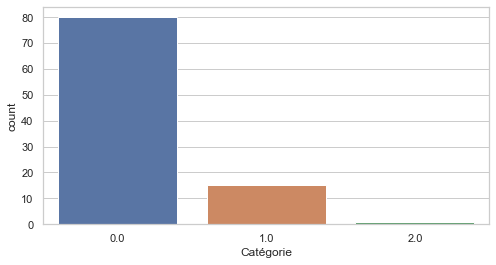

In [68]:
sns.countplot(data=output, x='Catégorie')
sns.set(rc={'figure.figsize':(8,3)})
sns.set_style('whitegrid')
plt.show()

## Nouvelles variables

In [69]:
# Nouveaux noms de modalités pour 'Sexe'
data['Sexe'].replace('f', 'Femme', inplace=True)
data['Sexe'].replace('m', 'Homme', inplace=True)
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie
313111,313184,0_2047,2021-09-27 05:25:27.959837,s_96190,c_8547,Femme,1977,5.99,0.0


In [70]:
# Nouvelle variable 'Âge'
year = datetime.now().year
data['Âge'] = year - data['Naissance']
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge
17998,18004,0_1157,2021-05-18 06:21:24.759348,s_36061,c_7993,Femme,1972,18.99,0.0,49


In [71]:
# Nouvelle variable 'Date fixe'
data['Date fixe'] = data['Date'].dt.date
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe
120828,120877,0_1303,2021-05-29 08:25:25.698304,s_41110,c_4967,Femme,1982,7.99,0.0,39,2021-05-29


In [72]:
# Nouvelle variable 'Mois'
data['Mois'] = pd.DatetimeIndex(data['Date']).month
data.sample(3)

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois
11468,11473,0_7,2021-09-21 21:09:20.535313,s_93411,c_2571,Homme,1960,7.99,0.0,61,2021-09-21,9
4009,4012,2_165,2021-06-05 02:42:29.197160,s_44217,c_4958,Homme,1999,71.99,2.0,22,2021-06-05,6
114120,114167,1_364,2021-03-15 11:26:55.489545,s_6619,c_1587,Femme,1975,10.30,1.0,46,2021-03-15,3


In [73]:
# Nouvelle variable 'Tranche' d'âge
data['Tranche'] = 0
data['Tranche'].loc[data[data['Âge']>=30].index] = 1
data['Tranche'].loc[data[data['Âge']>=40].index] = 2
data['Tranche'].loc[data[data['Âge']>=50].index] = 3
data['Tranche'].loc[data[data['Âge']>=60].index] = 4
data['Tranche'].loc[data[data['Âge']>=70].index] = 5
data['Tranche'].loc[data[data['Âge']>=80].index] = 6
data.sample(3)

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche
220094,220155,1_406,2021-06-03 16:57:38.170831,s_43586,c_6821,Homme,1941,24.81,1.0,80,2021-06-03,6,6
219596,219657,0_1563,2021-11-03 12:20:20.326045,s_114143,c_2951,Homme,1973,3.99,0.0,48,2021-11-03,11,2
25921,25929,1_425,2021-03-22 05:57:45.184931,s_9784,c_2032,Femme,1988,16.99,1.0,33,2021-03-22,3,1


# Analyse

## Chiffre d'affaires

💡 4 clients ont un nombre de commandes et un CA annuel anormalement élevé

### Fréquence d'achat

In [74]:
# Nombre total de transactions par client
frequence_achat = data.groupby(['ID_client']).count().reset_index()[['ID_client', 'index']]
frequence_achat.rename(columns={'index': 'Commandes'}, inplace=True)

# Nombre de transactions par mois
frequence_achat['Commandes_Mensuelles'] = frequence_achat['Commandes'] / 11

frequence_achat.sort_values(by='Commandes', ascending=False).head(10)

,ID_client,Commandes,Commandes_Mensuelles
677,c_1609,11861,1078.272727
6336,c_6714,4193,381.181818
2723,c_3454,3145,285.909091
4387,c_4958,2463,223.909091
7790,c_8026,184,16.727273
1772,c_2595,179,16.272727
7119,c_7421,178,16.181818
2513,c_3263,177,16.090909
5456,c_5922,177,16.090909
7316,c_760,176,16.000000


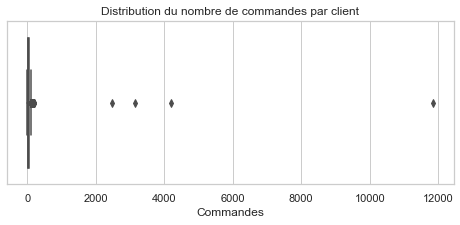

In [75]:
sns.boxplot(data=frequence_achat, x='Commandes')
plt.title('Distribution du nombre de commandes par client')
plt.show()

Courbe de Lorenz
Incide de Gini : 0.47292868420268763


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


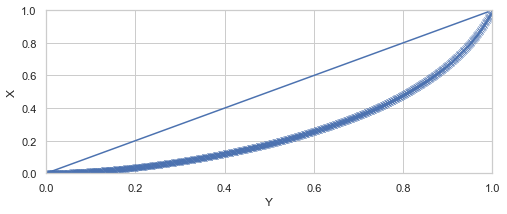

In [76]:
# Courbe de Lorenz sur les commandes mensuelles par client
lorenz(1000, frequence_achat['Commandes_Mensuelles'])

In [77]:
# Jointure de frequence_achat sur data
data = pd.merge(data, frequence_achat, how='left', on='ID_client')
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles
60816,64850,2_181,2021-07-08 06:06:33.820385,s_59407,c_2541,Femme,2003,57.99,2.0,18,2021-07-08,7,0,4,0.363636


### CA / client
- 10% des clients concentrent à eux-seuls 90% des plus gros chiffres d'affaires

In [78]:
# Chiffre d'affaires total par client
ca_client = data.pivot_table(index='ID_client', values='Prix', aggfunc='sum').reset_index()
ca_client.rename(columns={'Prix': 'CA client'}, inplace=True)

# Les 10 plus gros chiffre d'affaires par client
ca_client = ca_client.sort_values(by='CA client', ascending=False)
ca_client.head(10)

,ID_client,CA client
677,c_1609,151018.91
4387,c_4958,137456.83
6336,c_6714,69483.36
2723,c_3454,52835.11
7790,c_8026,2429.49
7119,c_7421,2406.17
7005,c_7319,2366.20
2513,c_3263,2346.34
8193,c_8392,2332.08
2108,c_2899,2313.54


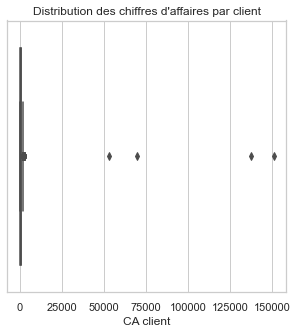

In [79]:
sns.boxplot(data=ca_client, x='CA client')
plt.title('Distribution des chiffres d\'affaires par client')
plt.show()

Courbe de Lorenz
Incide de Gini : 0.40535099336920277


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


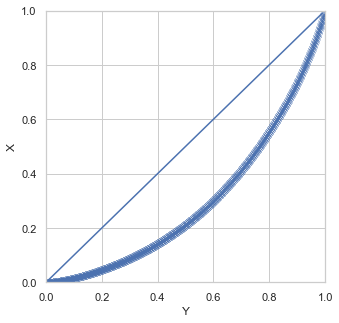

In [80]:
lorenz(1000, ca_client['CA client'])

# --> 90 % des clients détiennent les 10% du chiffre d'affaires les plus bas
# --> 10 % des clients détiennent les 90% du chiffre d'affaires les plus hauts

In [81]:
# Jointure de ca_client sur data
data = pd.merge(data, ca_client, how='left', on='ID_client')
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client
144843,154407,1_667,2021-10-31 20:02:01.295352,s_112880,c_3436,Femme,1963,29.99,1.0,58,2021-10-31,10,3,5,0.454545,90.32


### Panier moyen

In [82]:
# Panier moyen par client
panier_moyen = data.pivot_table(index='ID_client', values='Prix', aggfunc='mean').reset_index()
panier_moyen.rename(columns={'Prix': 'Panier_moyen'}, inplace=True)

# Les 10 plus gros paniers moyens
panier_moyen.sort_values(by='Panier_moyen', ascending=False).head(10)

,ID_client,Panier_moyen
3924,c_4540,181.9900
3760,c_4391,181.9900
7261,c_755,146.4050
6992,c_7307,134.2460
1521,c_2369,129.9100
7695,c_7941,120.5800
4524,c_5080,118.4900
5248,c_5734,108.6925
600,c_154,107.7050
4202,c_4791,106.5600


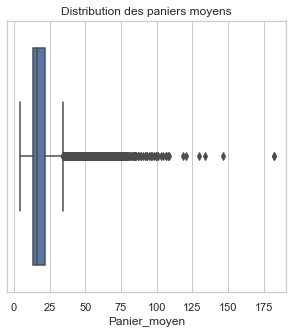

In [83]:
sns.boxplot(data=panier_moyen, x='Panier_moyen')
plt.title('Distribution des paniers moyens')
plt.show()

Courbe de Lorenz
Incide de Gini : 0.29743141958227226


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


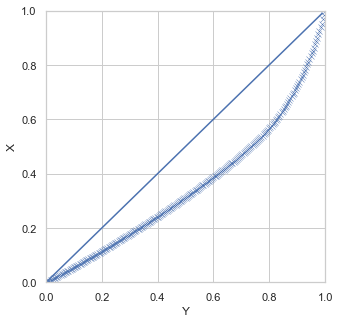

In [84]:
lorenz(250, panier_moyen['Panier_moyen'])

# --> Paniers normalement distribués

In [85]:
# Jointure de panier_moyen sur data
data = pd.merge(data, panier_moyen, how='left', on='ID_client')
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen
188086,200486,0_1758,2022-02-18 07:22:05.761131,s_166993,c_798,Homme,1985,12.64,0.0,36,2022-02-18,2,1,58,5.272727,930.53,16.043621


### B2B et B2C

- Distinction des clients entre particuliers et professionnels
- Les professionnels représentent 7% des transactions et du chiffre d'affaires
- Les professionnels ont des paniers moyens légèrement supérieurs à ceux des particuliers
- Les 16-30 ans ont un panier moyen largement supérieur aux clients plus âgés 
- Les 30-50 ans concentrent les paniers moyens les plus bas

In [86]:
# Création d'une variable 'Type' de client (2 modalités : particulier ou professionnel)
data['Type'] = 'Particulier'
data['Type'].loc[data[data['ID_client'].isin(ca_client.head(4)['ID_client'])].index] = 'Professionnel'
data.sample(3)

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type
125385,133725,1_414,2021-12-24 13:07:57.219618,s_139294,c_4027,Homme,1985,23.83,1.0,36,2021-12-24,12,1,87,7.909091,1127.52,12.96000,Particulier
302011,321809,1_400,2022-02-09 21:24:46.466286,s_162610,c_610,Homme,1989,16.60,1.0,32,2022-02-09,2,1,32,2.909091,606.52,18.95375,Particulier
259875,276926,1_249,2021-08-22 17:32:04.001729,s_79259,c_1962,Femme,2002,22.99,1.0,19,2021-08-22,8,0,24,2.181818,1134.24,47.26000,Particulier


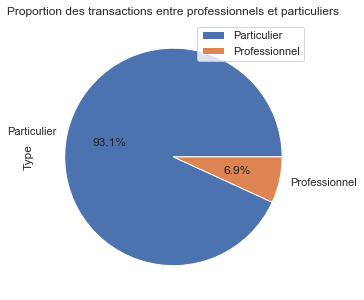

In [87]:
data['Type'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.title('Proportion des transactions entre professionnels et particuliers')
plt.show()

In [88]:
print('Proportion du chiffre d\'affaires total :',
    '\n- clients particuliers :',
    round(data[data['Type']=='Particulier']['Prix'].sum() / data['Prix'].sum() * 100), '%',
    '\n- clients professionnels :',
    round(data[data['Type']=='Professionnel']['Prix'].sum() / data['Prix'].sum() * 100), '%',)

Proportion du chiffre d'affaires total : 
- clients particuliers : 93.0 % 
- clients professionnels : 7.0 %


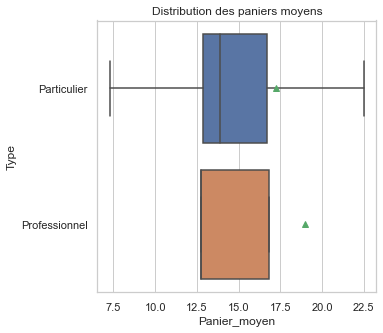

In [89]:
sns.boxplot(data=data, x='Panier_moyen', y='Type', showfliers=False, showmeans=True)
plt.title('Distribution des paniers moyens')
plt.show()

In [90]:
# Dataframe des clients particuliers
b2c = data[data['Type']=='Particulier']
b2c.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type
89548,95489,1_710,2021-12-24 19:53:10.311812,s_139447,c_5569,Homme,1975,27.94,1.0,46,2021-12-24,12,2,26,2.363636,396.82,15.262308,Particulier


In [91]:
# Dataframe des clients professionnels
b2b = data[data['Type']=='Professionnel']
b2b.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type
33389,35633,0_1418,2021-12-08 06:26:36.243283,s_131143,c_1609,Homme,1980,8.57,0.0,41,2021-12-08,12,2,11861,1078.272727,151018.91,12.732393,Professionnel


### CA / jour

In [92]:
# Chiffre d'affaires total par jour
ca_total = pd.pivot_table(data, index='Date fixe', values='Prix', aggfunc='sum').reset_index()
ca_total.rename(columns={'Prix': 'CA total'}, inplace=True)

# Les 10 jours aux plus gros chiffres d'affaires
ca_total.sort_values(by='CA total', ascending=False).head(10)

,Date fixe,CA total
321,2022-02-15,20307.88
330,2022-02-24,20194.71
320,2022-02-14,19997.23
317,2022-02-11,19918.68
332,2022-02-26,19759.58
322,2022-02-16,19753.38
316,2022-02-10,19596.94
244,2021-11-30,19529.83
318,2022-02-12,19483.30
326,2022-02-20,19338.65


In [93]:
# Jointure de ca_total sur data
data = pd.merge(data, ca_total, how='left', on='Date fixe')
data.sample()

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total
66714,71132,0_1536,2021-05-10 01:42:59.983424,s_32368,c_3823,Femme,1981,6.59,0.0,40,2021-05-10,5,2,68,6.181818,830.52,12.213529,Particulier,15843.7


Courbe de Lorenz
Incide de Gini : 0.04396439833409671


c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


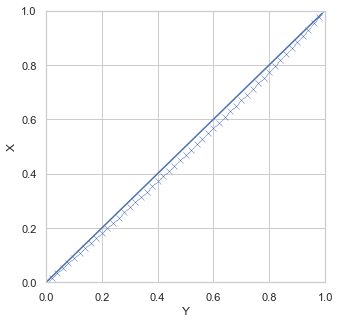

In [94]:
lorenz(50, data['CA total'])

# --> Les chiffres d'affaires par jour sont uniformément répartis

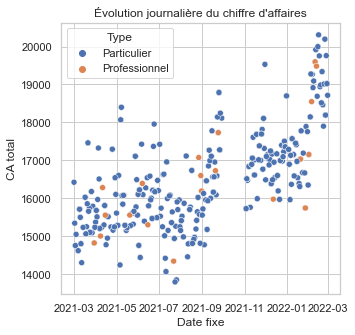

In [95]:
sns.scatterplot(data=data.sample(500), x='Date fixe', y='CA total', hue='Type')
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
plt.title('Évolution journalière du chiffre d\'affaires')
plt.show()

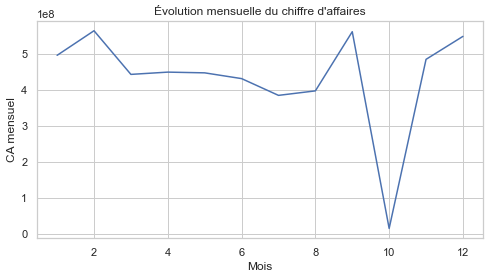

In [96]:
ca_mensuel = pd.pivot_table(data=data, index='Mois', values='CA total', aggfunc='sum').reset_index()
ca_mensuel.rename(columns={'CA total': 'CA mensuel'}, inplace=True)
sns.lineplot(data=ca_mensuel, x='Mois', y='CA mensuel')
plt.title('Évolution mensuelle du chiffre d\'affaires')
plt.show()

## Clients B2B

### Typologie

- Pas d'analyse sur le sexe ou l'âge
- Paniers moyens similaires à l'ensemble de la population, excepté 1 client à 55

In [97]:
# Profil des clients B2B
b2b.pivot_table(index='ID_client', values=['Âge', 'Naissance', 'CA client', 'Panier_moyen'])

,CA client,Naissance,Panier_moyen,Âge
ID_client,,,,
c_1609,151018.91,1980,12.732393,41
c_3454,52835.11,1969,16.799717,52
c_4958,137456.83,1999,55.808701,22
c_6714,69483.36,1968,16.571276,53


### Dates

- Pic des commandes en septembre et décembre
- Clients :
    - 1 : Son pic d'achats est en septembre

    - 2 : Son pic d'achats est en septembre également

    - 3 : Son pic d'achat est en décembre

    - 4 Son pic d'achats survient en février. Le pic correspond au début du 2ème semestre


- Des pics à des dates différentes pour chaque catégorie :
    - Catégorie 0 : pic en septembre
    - Catégorie 1 : pic en décembre
    - Catégorie 2 : pic en février

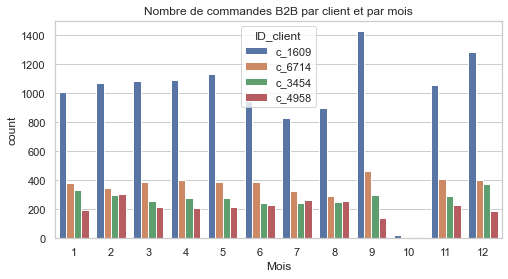

In [98]:
sns.countplot(data=b2b, x='Mois', hue='ID_client')
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style('whitegrid')
plt.title('Nombre de commandes B2B par client et par mois')
plt.show()

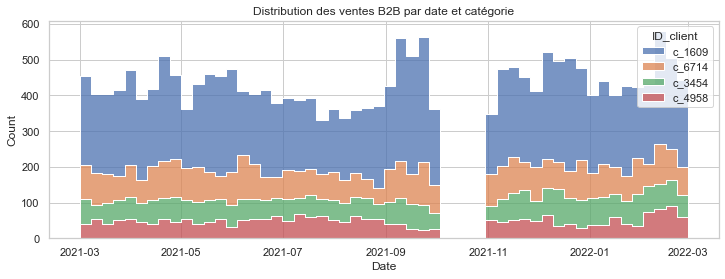

In [99]:
sns.histplot(data=b2b, x='Date', hue='ID_client', element='step', multiple='stack', bins=54)
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
plt.title('Distribution des ventes B2B par date et catégorie')
plt.show()

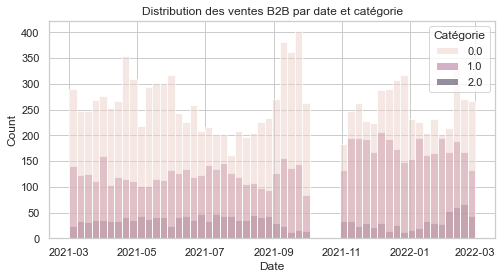

In [100]:
sns.histplot(data=b2b, x='Date', hue='Catégorie', bins=54)
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style('whitegrid')
plt.title('Distribution des ventes B2B par date et catégorie')
plt.show()

### Prix

- Le client 1609 a les prix les plus bas
- Les clients 6714 et 3454 ont des prix un peu plus élevés
- Le client 4958 a les prix d'achat les plus élevés

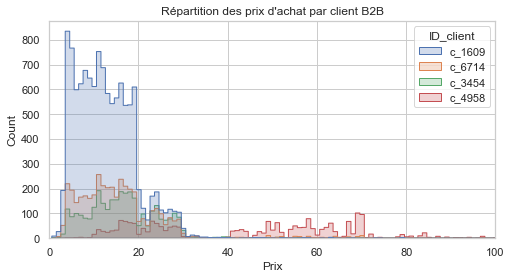

In [101]:
sns.histplot(data=b2b, x='Prix', hue='ID_client', element='step', binwidth=1)
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('whitegrid')
plt.title('Répartition des prix d\'achat par client B2B')
plt.xlim(0,100)
plt.show()

### Catégories

- Le client 4958 n'achète pas la catégorie 0
- Le client 1609 (le plus gros) n'achète pas la catégorie 2
- Les clients ont le même panier moyen dans les catégories 0 et 1

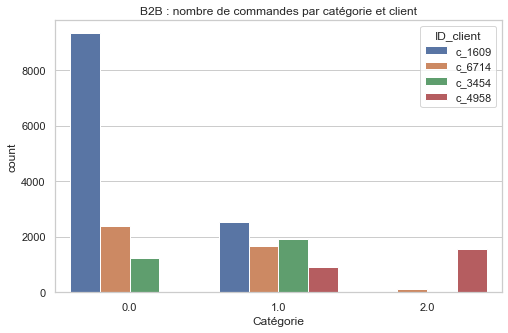

In [102]:
sns.countplot(data=b2b, x='Catégorie', hue='ID_client')
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('whitegrid')
plt.title('B2B : nombre de commandes par catégorie et client')
plt.show()

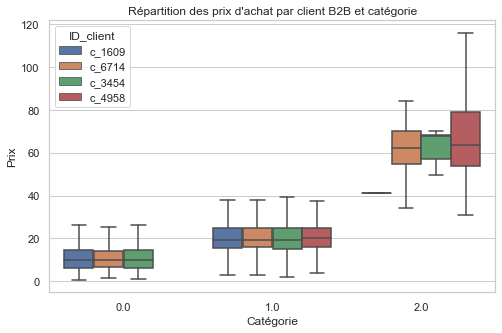

In [103]:
sns.boxplot(data=b2b, y='Prix', x='Catégorie', hue='ID_client', showfliers=False)
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('whitegrid')
plt.title('Répartition des prix d\'achat par client B2B et catégorie')
plt.show()

Client c_1609 
Mode du prix :  [4.99] 
Mode de la catégorie :  [0.]


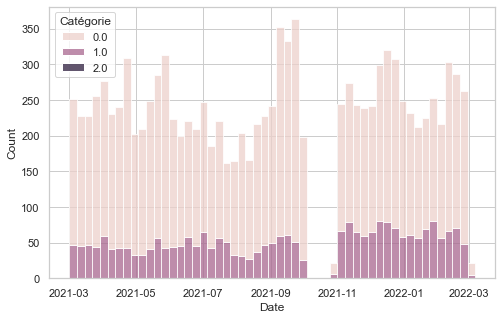

Client c_6714 
Mode du prix :  [15.99] 
Mode de la catégorie :  [0.]


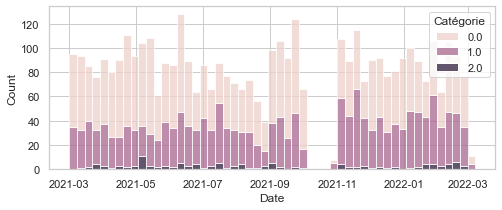

Client c_3454 
Mode du prix :  [15.99] 
Mode de la catégorie :  [1.]


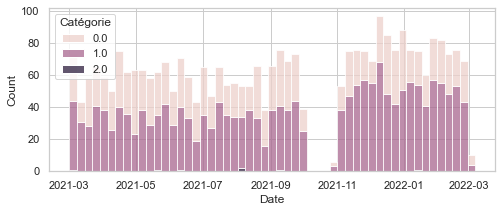

Client c_4958 
Mode du prix :  [68.99] 
Mode de la catégorie :  [2.]


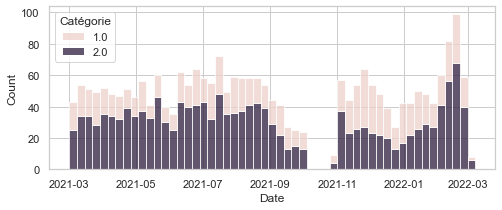

In [104]:
for i in b2b['ID_client'].unique():
    print(
        'Client', i,
        '\nMode du prix : ', b2b[b2b['ID_client']==i]['Prix'].mode().values,
        '\nMode de la catégorie : ', b2b[b2b['ID_client']==i]['Catégorie'].mode().values
        )
    sns.histplot(data=b2b[b2b['ID_client']==i], x='Date', hue='Catégorie', multiple='stack', binwidth=7)
    sns.set(rc={'figure.figsize':(8,3)})
    sns.set_style('whitegrid')
    plt.show()

## Clients B2C

### Sexe

- Effectifs identiques pour chaque sexe
- Distribution des dates identique pour chaque sexe
- Pas de lien entre le sexe et les dates d'achat
- Distribution des âges identique pour chaque sexe
- Distribution des prix identique pour chaque sexe
- Les 2 sexes achètent autant dans chaque catégorie

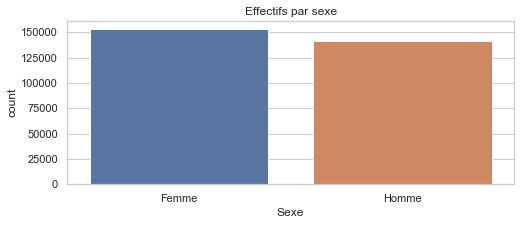

In [105]:
sns.countplot(data=b2c, x='Sexe')
sns.set(rc={'figure.figsize':(5,3)})
plt.title('Effectifs par sexe')
plt.show()

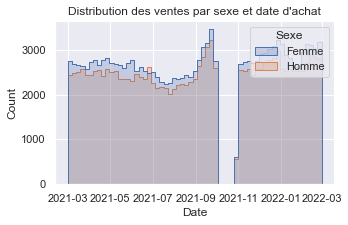

In [106]:
sns.histplot(b2c, x='Date', hue='Sexe', element='step')
plt.title('Distribution des ventes par sexe et date d\'achat')
plt.show()

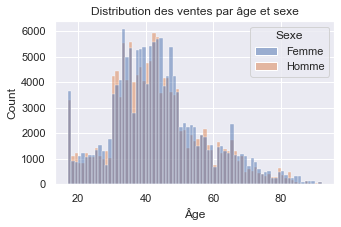

In [107]:
sns.histplot(b2c, x='Âge', hue='Sexe', binwidth=1)
plt.title('Distribution des ventes par âge et sexe')
plt.show()

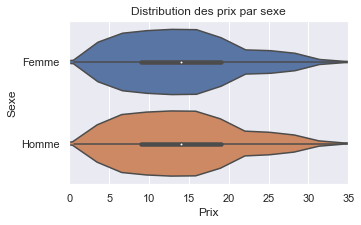

In [108]:
sns.violinplot(data=b2c, x='Prix', y='Sexe', showfliers=False)
plt.xlim([0,35])
plt.title('Distribution des prix par sexe')
plt.show()

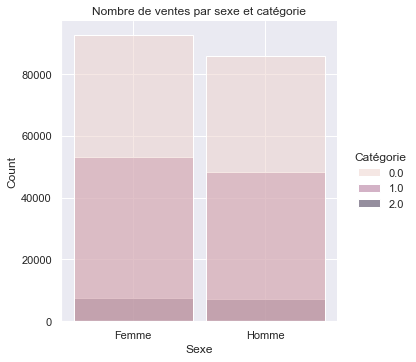

In [109]:
sns.displot(b2c, x="Sexe", hue='Catégorie', shrink=.9)
plt.title('Nombre de ventes par sexe et catégorie')
plt.show()

### Date d'achat
- La catégorie 2 présente un creux pendant les fêtes de fin d'année

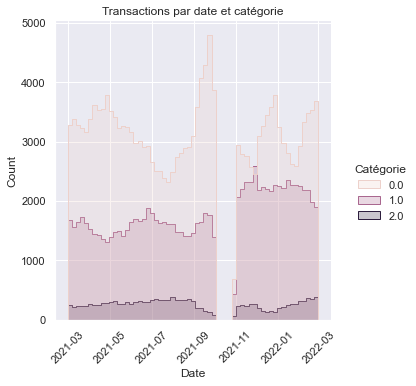

In [110]:
sns.displot(data=b2c, x='Date', hue='Catégorie', element='step')
plt.title('Transactions par date et catégorie')
plt.xticks(rotation=45)
plt.show()

Catégorie 0.0


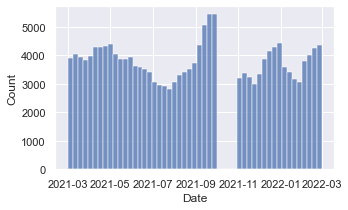

Catégorie 2.0


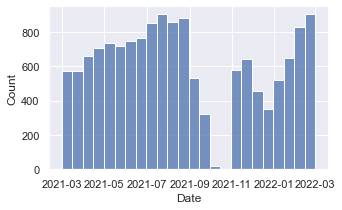

Catégorie 1.0


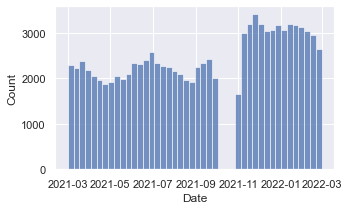

In [111]:
for i in b2c['Catégorie'].unique():
    print('Catégorie', i)
    sns.histplot(data=b2c[b2c['Catégorie']==i], x='Date')
    plt.show()

### Âge

- Concentration autour de 40 ans

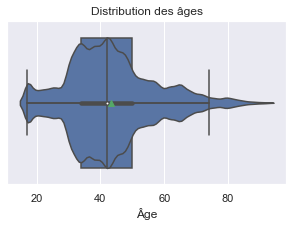

In [112]:
sns.boxplot(data=b2c, x='Âge', showfliers=False, showmeans=True)
sns.violinplot(data=b2c, x='Âge', showfliers=False)
plt.title('Distribution des âges')
plt.show()

### Âge et CA

- Les 30-50 ans concentrent les plus gros chiffres d'affaires
- Les 16-30 ans concentrent également de gros chiffres d'affaires, dans la catégorie 2

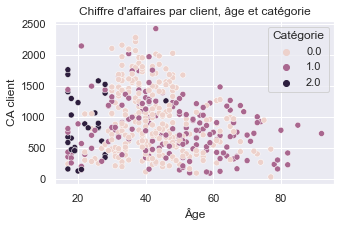

In [113]:
sns.scatterplot(data=b2c.sample(500), x='Âge', y='CA client', hue='Catégorie')
plt.title('Chiffre d\'affaires par client, âge et catégorie')
plt.show()

### Âge et fréquence d'achat

### Âge et panier moyen

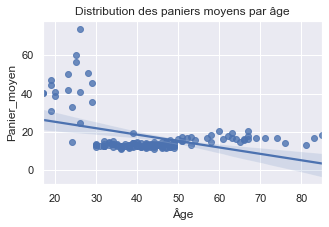

In [114]:
sns.regplot(data=b2c.sample(150), x='Âge', y='Panier_moyen')
plt.title('Distribution des paniers moyens par âge')
plt.show()

### Âge et prix

3 tranches d'âge se distinguent en prix d'achat moyen :
- Les 16-28 ans achètent des livres beaucoup plus chers, de 20 à 60€
- À partir de 29 ans, les prix d'achat sont largement et uniformément inférieurs à 20€
- À l'intérieur de cette classe, les 49 ans et plus achètent des livres légèrement plus chers 

Résultats des tests :
- Le test de Pearson n'indique pas de corrélation entre l'âge et le prix.
- Par contre, un découpage des âges en 3 classes valide ANOVA et

- Le test de Pearson confirme la corrélation

Les 3 buckets d'âges ne sont pas vraiment corrélés à la catégorie (seuls les 16-28 ans consomment la catégorie 2, tout en consommant également les autres)

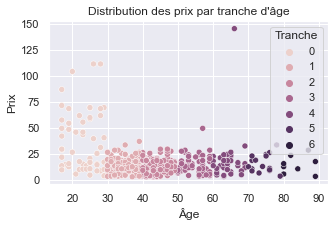

In [115]:
sns.scatterplot(data=b2c.sample(500), x='Âge', y='Prix', hue='Tranche')
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('whitegrid')
plt.title('Distribution des prix par tranche d\'âge')
plt.show()

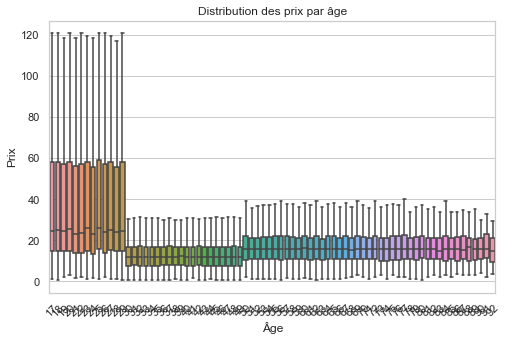

In [116]:
sns.boxplot(data=b2c, x='Âge', y='Prix', showfliers=False)
sns.set(rc={'figure.figsize':(16,4)})
sns.set_style('whitegrid')
plt.title('Distribution des prix par âge')
plt.xticks(rotation=45)
plt.show()

### Âge et catégorie

- Les catégories 0 et 1 ont les mêmes formes d'histogramme, excepté une plus forte densité entre 30 et 50 ans
- La catégorie 2 est achetée par des clients de moins de 30 ans

💡 La catégorie 2 est achetée par des clients beaucoup plus jeunes

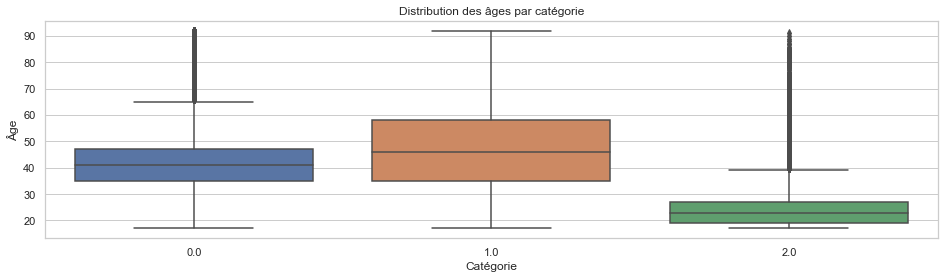

In [117]:
sns.boxplot(data=b2c, x='Catégorie', y='Âge')
plt.title('Distribution des âges par catégorie')
plt.show()

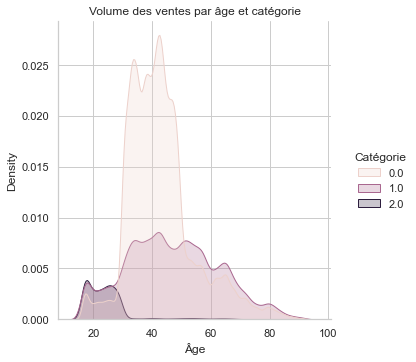

In [118]:
sns.displot(data=b2c, x='Âge', hue='Catégorie', kind='kde', fill=True)
plt.title('Volume des ventes par âge et catégorie')
plt.show()

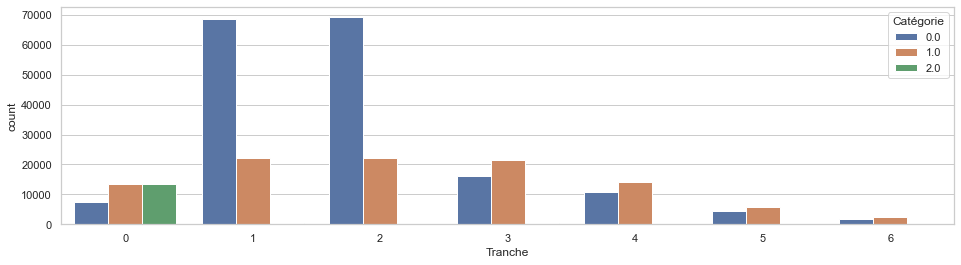

In [119]:
sns.countplot(data=b2c, x='Tranche', hue='Catégorie')
plt.show()

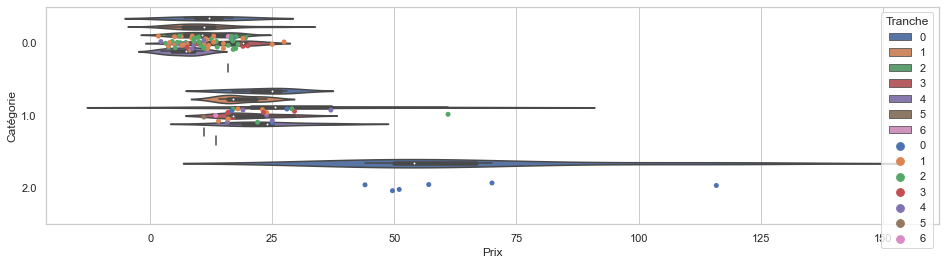

In [120]:
df = b2c.sample(100)
sns.stripplot(data=df, y='Catégorie', x='Prix', hue='Tranche', orient='h', jitter=True)
sns.violinplot(data=df, y='Catégorie', x='Prix', hue='Tranche', orient='h')
plt.show()

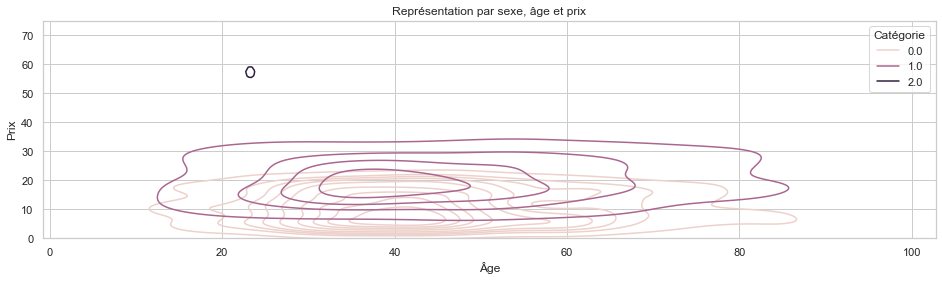

In [121]:
sns.kdeplot(data=b2c.sample(1000), y='Prix', x='Âge', hue='Catégorie')
plt.title('Représentation par sexe, âge et prix')
plt.ylim(0, 75)
plt.show()

## Produits

### Prix

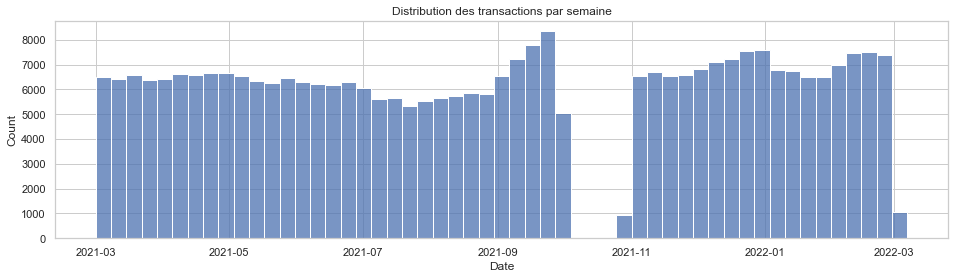

In [122]:
sns.histplot(data=data, x='Date', binwidth=7)
plt.title('Distribution des transactions par semaine')
plt.show()

### Catégorie

- la catégorie 0 représente 60% des transactions
- la catégorie 2 ne réprésente que 5% des transactions
- les catégories correspondent à 3 classes de prix ordonnées

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


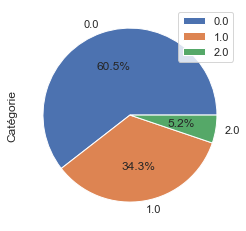

In [123]:
data['Catégorie'].value_counts(normalize=True).plot(
    kind='pie',
    legend=True,
    autopct='%1.1f%%'
)
plt.show()

### Prix et catégorie

- Les catégories correspondent à 3 gammes de prix ordonnées

In [124]:
# Moyenne de 'Prix'
print('Moyenne de tous les prix :', data['Prix'].mean())

Moyenne de tous les prix : 17.377682797229337


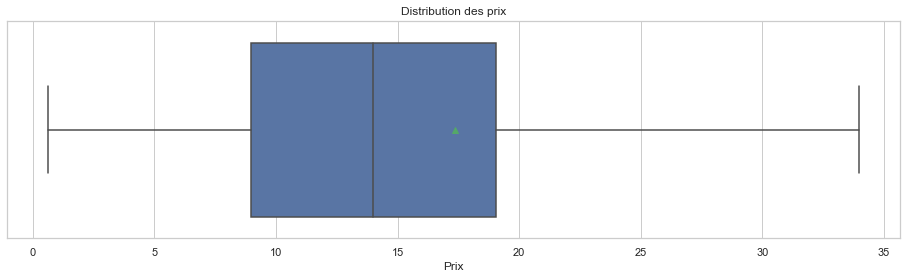

In [125]:
sns.boxplot(data=data, x='Prix', showmeans=True, showfliers=False)
plt.title('Distribution des prix')
plt.show()

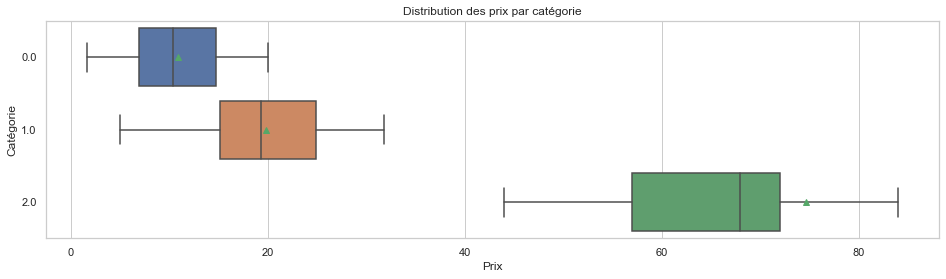

In [126]:
sns.boxplot(
    data=data.sample(500), y='Catégorie', x='Prix', 
    showmeans=True, showfliers=False, orient='h')
plt.title('Distribution des prix par catégorie')
plt.show()

### Catégorie et date

# Tests

## Sexe et catégorie

- Pas de corrélation

In [127]:
# Nouvelle variable sexe, en chiffres
data['SexeN'] = 0
data['SexeN'].loc[data[data['Sexe']=='Homme'].index] = 1
data['SexeN'] = pd.to_numeric(data['SexeN'])
data.sample()

# Variable 'Catégorie' en numérique
# data['Catégorie'] = pd.to_numeric(data['Catégorie'])

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total,SexeN
115953,123670,0_1070,2021-07-30 20:59:15.387887,s_69253,c_6355,Femme,1989,4.38,0.0,32,2021-07-30,7,1,24,2.181818,299.83,12.492917,Particulier,15955.34,0


In [128]:
# Nouvelle variable sexe, en chiffres
data['SexeN'] = 1
data['SexeN'].loc[data[data['Sexe']=='Homme'].index] = 2
data['SexeN'] = pd.to_numeric(data['SexeN'])
data.sample()

# Variable 'Catégorie' en numérique
# data['Catégorie'] = pd.to_numeric(data['Catégorie'])

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total,SexeN
135196,144155,0_1108,2021-05-27 10:53:33.283020,s_40227,c_1609,Homme,1980,17.45,0.0,41,2021-05-27,5,2,11861,1078.272727,151018.91,12.732393,Professionnel,16077.01,2


Test de Chi 2 (2 catégorielles)
Stat = 0.462
p-value = 0.79388624502486992984273683759965934
H0: the two samples are independent.

Conditions :
- Observations used in the calculation of the contingency table are independent. 
- 25 or more examples in each cell of the contingency table.

-------------------------------------------------------

Table de contingence :
Sexe       Femme  Homme
Catégorie              
0.0          447    431
1.0          271    266
2.0           40     45

-------------------------------------------------------

Table de contingence normalisée :
             Sexe                
Sexe        Femme   Homme     All
Catégorie                        
0.0         58.97   58.09   58.53
1.0         35.75   35.85   35.80
2.0          5.28    6.06    5.67
All        100.00  100.00  100.00

-------------------------------------------------------


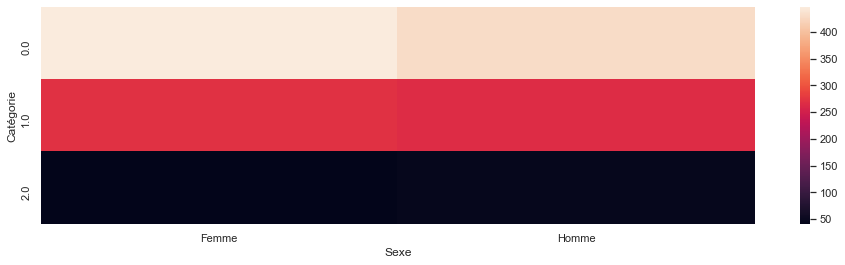

In [129]:
# Test de Chi 2
df = data.sample(1500)
# table = df['SexeN'], df['Catégorie']
table = pd.crosstab(df['Catégorie'], df['Sexe'], margins=False)
stat, p, dof, expected = stats.chi2_contingency(table)
print('Test de Chi 2 (2 catégorielles)')
print('Stat = %.3f\np-value = %.35f' % (stat, p))
if p > .05:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')
print('\nConditions :\n'
      '- Observations used in the calculation of the contingency table are independent.',
      '\n- 25 or more examples in each cell of the contingency table.') 

print('\n' + '-' * 55)

# Table de contingence
crosstab = pd.crosstab(df['Catégorie'], df['Sexe'], margins=False)
print('\nTable de contingence :')
print(crosstab)

print('\n' + '-' * 55)

# Table de contingence normalisée
table, results = rp.crosstab(df['Catégorie'], df['Sexe'], prop='col', test='chi-square')
print('\nTable de contingence normalisée :')
print(table)

print('\n' + '-' * 55)

# Heatmap
sns.heatmap(crosstab)
plt.show()

## Âge et catégorie

In [130]:
# Nouvelle variable 'Tranche' d'âge
data['Tranche'] = 0
data['Tranche'].loc[data[data['Âge']>=30].index] = 1
data['Tranche'].loc[data[data['Âge']>=40].index] = 2
data['Tranche'].loc[data[data['Âge']>=50].index] = 3
data['Tranche'].loc[data[data['Âge']>=60].index] = 4
data['Tranche'].loc[data[data['Âge']>=70].index] = 5
data['Tranche'].loc[data[data['Âge']>=80].index] = 6
data.sample()

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total,SexeN
118345,126212,2_213,2021-10-31 01:14:07.362398,s_112496,c_7524,Femme,2000,189.99,2.0,21,2021-10-31,10,0,12,1.090909,597.47,49.789167,Particulier,16405.12,1


In [131]:
# Nouvelle variable 'Tranche' d'âge
data['Tranche'] = 1
data['Tranche'].loc[data[data['Âge']>=30].index] = 2
data['Tranche'].loc[data[data['Âge']>=40].index] = 3
data['Tranche'].loc[data[data['Âge']>=50].index] = 4
data['Tranche'].loc[data[data['Âge']>=60].index] = 5
data['Tranche'].loc[data[data['Âge']>=70].index] = 6
data['Tranche'].loc[data[data['Âge']>=80].index] = 7
data.sample()

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total,SexeN
15251,16314,0_1199,2021-06-11 14:39:07.370981,s_47212,c_4749,Femme,1979,14.99,0.0,42,2021-06-11,6,3,37,3.363636,579.03,15.649459,Particulier,15850.91,1


Test de Chi 2 (2 catégorielles)
Stat = 8749.903
p-value = 1.00000000000000000000000000000000000
H0: the two samples are independent.

Conditions :
- Observations used in the calculation of the contingency table are independent. 
- 25 or more examples in each cell of the contingency table.

-------------------------------------------------------

Table de contingence :
Tranche      1     2     3    4    5    6   7
Catégorie                                    
0.0        198  2149  2518  651  339  143  61
1.0        437   701   756  811  452  194  69
2.0        478     9     7   13    9    3   2

-------------------------------------------------------

Table de contingence normalisée :
          Tranche                                                        
Tranche         1       2       3       4       5       6       7     All
Catégorie                                                                
0.0         17.79   75.17   76.74   44.14   42.38   42.06   46.21   60.59
1.0        

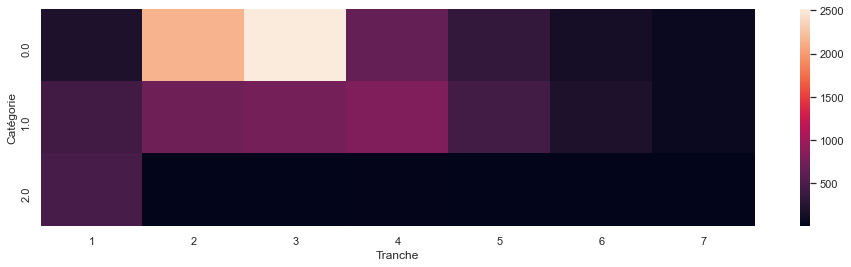

In [132]:
# Test de Chi 2
df = data.sample(10000)
table = df['Tranche'], df['Catégorie']
stat, p, dof, expected = stats.chi2_contingency(table)
print('Test de Chi 2 (2 catégorielles)')
print('Stat = %.3f\np-value = %.35f' % (stat, p))
if p > .05:
    print('H0: the two samples are independent.')
else:
    print('H1: there is a dependency between the samples.')
print('\nConditions :\n'
      '- Observations used in the calculation of the contingency table are independent.',
      '\n- 25 or more examples in each cell of the contingency table.') 

print('\n' + '-' * 55)

# Table de contingence
crosstab = pd.crosstab(df['Catégorie'], df['Tranche'], margins=False)
print('\nTable de contingence :')
print(crosstab)

print('\n' + '-' * 55)

# Table de contingence normalisée
table, results = rp.crosstab(df['Catégorie'], df['Tranche'], prop='col', test='chi-square')
print('\nTable de contingence normalisée :')
print(table)

print('\n' + '-' * 55)

# Heatmap
sns.heatmap(crosstab)
plt.show()

## Âge et prix

In [133]:
# Nouvelle variable 'Tranche' d'âge
data['Tranche'] = 0
data['Tranche'].loc[data[data['Âge']>=30].index] = 1
data['Tranche'].loc[data[data['Âge']>=40].index] = 2
data['Tranche'].loc[data[data['Âge']>=50].index] = 3
data['Tranche'].loc[data[data['Âge']>=60].index] = 4
data['Tranche'].loc[data[data['Âge']>=70].index] = 5
data['Tranche'].loc[data[data['Âge']>=80].index] = 6
data.sample()

c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guifo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,index,ID_produit,Date,ID_session,ID_client,Sexe,Naissance,Prix,Catégorie,Âge,Date fixe,Mois,Tranche,Commandes,Commandes_Mensuelles,CA client,Panier_moyen,Type,CA total,SexeN
120310,128311,1_601,2021-04-04 21:47:21.005316,s_16035,c_1513,Homme,2002,21.99,1.0,19,2021-04-04,4,0,33,3.0,1473.53,44.652424,Particulier,15966.6,2


Test d'ANOVA

Moyennes des modalités :
Tranche
0    41.024913
1    13.176297
2    13.386422
3    17.368974
4    15.643237
5    18.315935
6    17.129500
Name: Prix, dtype: float64

p-value : 6.377317368393788e-38 
stat : 168.5122412042836
H1: one or more of the means of the samples are unequal.

Conditions :
1. normalité des résidus

-------------------------------------------------------

Condition 1 : normalité des résidus (test de Shapiro)

stats : 0.5954694151878357 
p-value : 0.0
H0 rejetée : distribution probablement pas normale


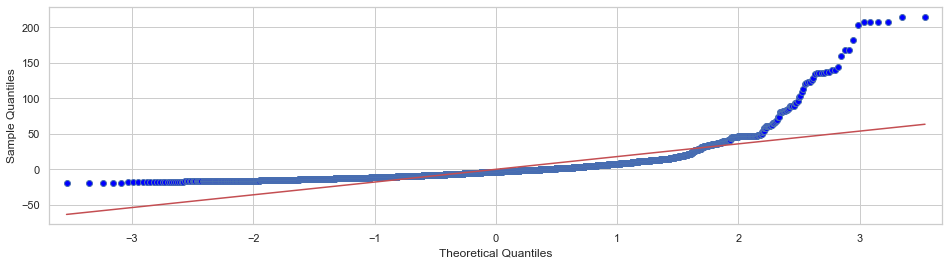

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


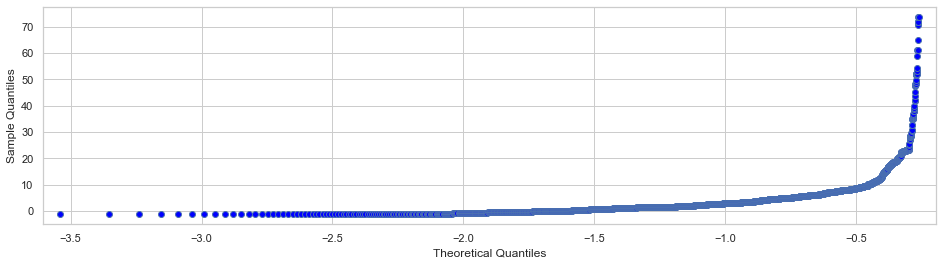


-------------------------------------------------------

Condition 2 : homoscédasticité (des résidus ?)

Test de Levene 
stats : 16.071068902560484 
p-value : 2.6518436079122187e-16
H1: les variances ne sont pas égales (essayer Welch ANOVA)

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed

-------------------------------------------------------

Test de Welch

p-value : 0.0 
stat : 60.07325866250708
H1: one or more of the means of the samples are unequal.


In [134]:
# ANOVA sur les 7 tranches d'âge
samples = 5000
df = data.sample(samples)

# Test d'ANOVA entre catégorielle et quantitative
model = smf.ols('Prix ~ Tranche', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('Test d\'ANOVA\n')
print('Moyennes des modalités :')
print(df.groupby('Tranche').mean()['Prix'])
print('\np-value :', p, '\nstat :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.'
         '\n\nConditions :'
         '\n1. normalité des résidus')
print('\n' + '-' * 55)

# Test de Shapiro sur les résidus
print('\nCondition 1 : normalité des résidus (test de Shapiro)')
p = stats.shapiro(model.resid)[1]
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(model.resid, line='s')
plt.show()

# Test de Shapiro sur les résidus après boxcox
residus = boxcox1p(model.resid, 0.75)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus, line='s')
plt.show()
print('\n' + '-' * 55)

# Test de Levene sur les 7 tranches
samples = 50
a = df[df['Tranche']==0]['Prix'].sample(samples).values
b = df[df['Tranche']==1]['Prix'].sample(samples).values
c = df[df['Tranche']==2]['Prix'].sample(samples).values
d = df[df['Tranche']==3]['Prix'].sample(samples).values
e = df[df['Tranche']==4]['Prix'].sample(samples).values
f = df[df['Tranche']==5]['Prix'].sample(samples).values
g = df[df['Tranche']==6]['Prix'].sample(samples).values
stat, p = stats.levene(a, b, c, d, e, f, g)
print('\nCondition 2 : homoscédasticité (des résidus ?)\n\nTest de Levene',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed')   
print('\n' + '-' * 55)

# Test de Welch entre catégorielle et quantitative
stat, p = stats.ttest_ind(df['Prix'], df['Tranche'])
print('\nTest de Welch\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.')
    
# --> Les résidus sont considérés normaux, la condition de l'ANOVA est remplie
# --> La distribution des résidus n'est pas normale
# --> Pas d'homoscédasticité, il faut essayer le test de Welch

## Catégorie et prix

In [135]:
# Moyennes des prix par catégorie
print('Moyenne des prix par catégorie :')
data.groupby('Catégorie').mean()['Prix']

Moyenne des prix par catégorie :


Catégorie
0.0    10.646268
1.0    20.485779
2.0    75.245566
Name: Prix, dtype: float64

Test d'ANOVA

Moyennes des modalités :
Catégorie
0.0    10.701997
1.0    20.427637
2.0    75.704038
Name: Prix, dtype: float64

p-value : 3.974244540830375e-138 
stat : 871.0121420935949
H1: one or more of the means of the samples are unequal.

Conditions :
1. normalité des résidus

-------------------------------------------------------

Condition 1 : normalité des résidus (test de Shapiro)

stats : 0.6690953969955444 
p-value : 3.094010957290623e-40
H0 rejetée : distribution probablement pas normale


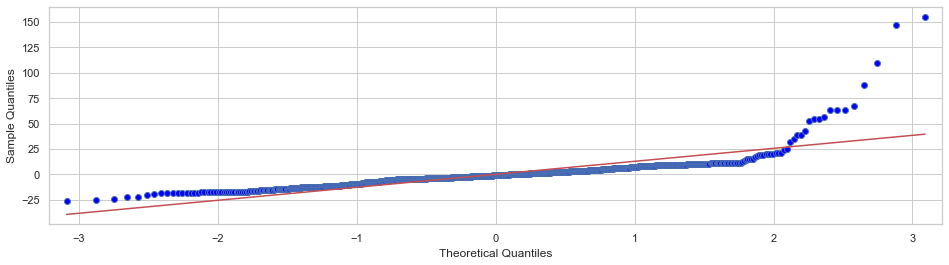

Normalité des résidus après boxcox :
stats : nan 
p-value : 1.0
H0 acceptée : distribution normale


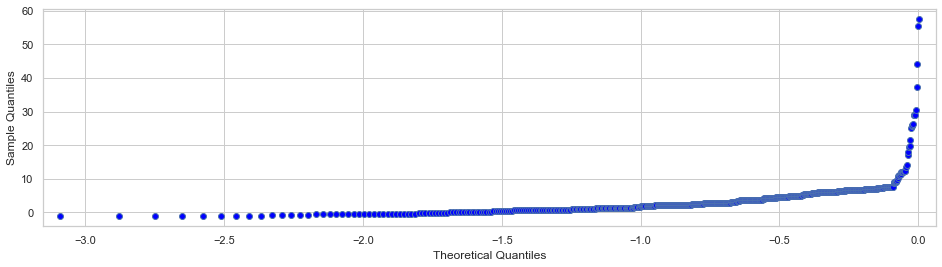


-------------------------------------------------------

Condition 2 : homoscédasticité (des résidus ?)

Test de Levene 
stats : 17.910051819241776 
p-value : 1.0941168841106925e-07
H1: les variances ne sont pas égales (essayer Welch ANOVA)

Conditions :
- The samples from the populations under consideration are independent 
- The populations under consideration are approximately normally distributed

-------------------------------------------------------

Test de Welch

p-value : 1.1342329565885794e-169 
stat : 30.67652105212494
H1: one or more of the means of the samples are unequal.


In [136]:
# ANOVA sur les 3 catégories
samples = 1000
df = data.sample(samples)

# Test d'ANOVA entre catégorielle et quantitative
model = smf.ols('Prix ~ Catégorie', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p = anova_table['PR(>F)'][0]
print('Test d\'ANOVA\n')
print('Moyennes des modalités :')
print(df.groupby('Catégorie').mean()['Prix'])
print('\np-value :', p, '\nstat :', anova_table['F'][0])
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.'
         '\n\nConditions :'
         '\n1. normalité des résidus')
print('\n' + '-' * 55)

# Test de Shapiro sur les résidus
print('\nCondition 1 : normalité des résidus (test de Shapiro)')
p = stats.shapiro(model.resid)[1]
print('\nstats :', stats.shapiro(model.resid)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(model.resid, line='s')
plt.show()

# Test de Shapiro sur les résidus après boxcox
residus = boxcox1p(model.resid, 0.75)
p = stats.shapiro(residus)[1]
print('Normalité des résidus après boxcox :'
    '\nstats :', stats.shapiro(residus)[0],
    '\np-value :', p)
if p>.05:
    print('H0 acceptée : distribution normale')
else:
    print('H0 rejetée : distribution probablement pas normale')
qqplot(residus, line='s')
plt.show()
print('\n' + '-' * 55)

# Test de Levene sur les 3 catégories
samples = 50
a = df[df['Catégorie']==0]['Prix'].sample(samples).values
b = df[df['Catégorie']==1]['Prix'].sample(samples).values
c = df[df['Catégorie']==2]['Prix'].sample(samples).values
stat, p = stats.levene(a, b, c)
print('\nCondition 2 : homoscédasticité (des résidus ?)\n\nTest de Levene',
    '\nstats :', stat,
    '\np-value :', p)
if p > 0.05:
    print('H0: les variances sont égales')
else:
    print('H1: les variances ne sont pas égales (essayer Welch ANOVA)')
print('\nConditions :'
      '\n- The samples from the populations under consideration are independent',
      '\n- The populations under consideration are approximately normally distributed')   
print('\n' + '-' * 55)

# Test de Welch entre catégorielle et quantitative
stat, p = stats.ttest_ind(df['Prix'], df['Catégorie'])
print('\nTest de Welch\n')
print('p-value :', p, '\nstat :', stat)
if p > 0.05:
    print('H0: the means of the samples are equal.')
else:
    print('H1: one or more of the means of the samples are unequal.')
    

# --> Les résidus sont considérés normaux, la condition de l'ANOVA est remplie
# --> La distribution des résidus n'est pas normale
# --> Pas d'homoscédasticité, il faut essayer le test de Welch

# Conclusion


## Résultats

- Le sexe n'est pas corrélé à la catégorie
- Sexe : les femmes achètent autant que les hommes, à la même fréquence et dans les mêmes prix. Le sexe n'est corrélé à aucune variable


## Recommandations

- ...

## Références

Tests :
- [17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)
- [Independent and identically distributed random variables](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
- [Q-Q Plots Explained](https://medium.com/preai/q-q-plots-explained-75f5bc6d68be)


ANOVA :
- [ANOVA explained without math: Why analyze variances to compare means?](https://medium.com/@peterflom/anova-why-analyze-variances-to-compare-means-e3d4bbd3c05)
- [ANOVA using Python](https://reneshbedre.github.io/blog/anova.html)
- [F-tests and ANOVAs — Examples with the Iris dataset](https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0)
- [Welch’s t-test](https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/)

Courbe de Lorenz :
- [Plot Lorenz Curve in Python](https://zhiyzuo.github.io/Plot-Lorenz/)
- [Clearly Explained: Gini coefficient and Lorenz curve](https://towardsdatascience.com/clearly-explained-gini-coefficient-and-lorenz-curve-fe6f5dcdc07)